In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn import linear_model, metrics, model_selection, preprocessing, ensemble
from sklearn.model_selection import StratifiedShuffleSplit
from scipy import sparse
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
import matplotlib.ticker as mtick

In [5]:
from plot_function import plot_randomforest

In [6]:
Ames = pd.read_csv('AmesFinalDB.csv')
Ames.drop(['Unnamed: 0'],axis=1,inplace=True)
Ames.head(3)

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Lot_Shape,Land_Contour,Lot_Config,Land_Slope,Neighborhood,Condition_1,...,Mo_Sold,Sale_Type,Sale_Condition,SalePrice,exterior,basement_type,basement_area,age,remodeled_age,garage_age
0,20,RL,141.0,31770,IR1,Lvl,Corner,Gtl,NAmes,Norm,...,5,WD,Normal,215000,0,BLQ_Unf,639.0,50,0,50.0
1,20,RH,80.0,11622,Reg,Lvl,Inside,Gtl,NAmes,Feedr,...,6,WD,Normal,105000,VinylSd_VinylSd,Rec_LwQ,612.0,49,0,49.0
2,20,RL,81.0,14267,IR1,Lvl,Corner,Gtl,NAmes,Norm,...,6,WD,Normal,172000,Wd Sdng_Wd Sdng,ALQ_Unf,923.0,52,0,52.0


In [7]:
print('Ames shape is : ', str(Ames.shape))

Ames shape is :  (2930, 59)


In [8]:
categorical_features = ['MS_SubClass','MS_Zoning','Lot_Shape','Land_Contour','Lot_Config','Land_Slope']
categorical_features.extend(['Neighborhood','Condition_1','Bldg_Type','House_Style','Roof_Style'])
categorical_features.extend(['Mas_Vnr_Type','Exter_Qual','Exter_Cond','Foundation','Bsmt_Qual','Bsmt_Exposure'])
categorical_features.extend(['basement_type','Heating_QC','Garage_Finish','Mo_Sold','Sale_Type','Sale_Condition','Kitchen_Qual'])
categorical_features.extend(['exterior','Fireplace_Qu','Garage_Type','Garage_Qual'])

Ordinal_featues = ['Overall_Qual','Overall_Cond','Bsmt_Full_Bath','Bsmt_Half_Bath','Bedroom_AbvGr','Full_Bath',
                  'Half_Bath','Kitchen_AbvGr','TotRms_AbvGrd','Fireplaces','Garage_Cars']

Continous_features = ['Lot_Frontage','Lot_Area','age','remodeled_age','Mas_Vnr_Area','basement_area']
Continous_features.extend(['Bsmt_Unf_SF','Total_Bsmt_SF','1st_Flr_SF','2nd_Flr_SF','Low_Qual_Fin_SF'])
Continous_features.extend(['Gr_Liv_Area'])              
Continous_features.extend(['Garage_Area'])
Continous_features.extend(['Wood_Deck_SF','Open_Porch_SF','Enclosed_Porch','Screen_Porch','Pool_Area'])
Continous_features.extend(['SalePrice','garage_age'])

In [9]:
X = Ames.drop(['SalePrice'],axis=1).copy()
Y = Ames.SalePrice.copy()

In [10]:
AmesFinal = X.drop(categorical_features,axis = 1).copy()
AmesData = AmesFinal.values
AmesCol = AmesFinal.columns

for ifeature in categorical_features:
    
    temp_df = pd.get_dummies(Ames.loc[:,ifeature], prefix = ifeature, prefix_sep = '_')
    AmesCol = list(AmesCol) + list(temp_df.columns)
    temp_data = temp_df.values
    AmesData = np.hstack([AmesData,temp_data])
    
AmesFinal = pd.DataFrame(AmesData, columns = AmesCol)

In [11]:
fitted_data, fitted_lambda = stats.boxcox(Y)
print('Lambda parameter is :', fitted_lambda)

Lambda parameter is : 0.007644244604190389


In [12]:
X = AmesFinal
Y = fitted_data

In [13]:
Y_stratify = pd.cut(Y,bins = 10)

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 144, stratify = Y_stratify)

In [15]:
print(np.min(Y))
print(np.max(Y))

9.80651043059859
14.25940038893919


In [16]:
RFR = ensemble.RandomForestRegressor()
RFR.set_params(n_estimators = 100, max_depth = 10, min_samples_leaf = 20)

RandomForestRegressor(max_depth=10, min_samples_leaf=20)

In [17]:
RFR.fit(X_train, Y_train)
R2_train = np.round(RFR.score(X_train,Y_train),3)
R2_test  = np.round(RFR.score(X_test,Y_test),3)
print('Training score is :'+ str(R2_train))
print('Testing  score is :'+ str(R2_test))

Training score is :0.884
Testing  score is :0.847


In [18]:
type(X)

pandas.core.frame.DataFrame

In [19]:
zip_data = zip(X.columns, RFR.feature_importances_)
sorted_features = sorted(zip_data,key = lambda x:x[1],reverse=True)
sorted_features_df = pd.DataFrame(sorted_features, columns = ['Feature','Score'])
sorted_features_df.head()

,Feature,Score
0,Overall_Qual,0.624791
1,Gr_Liv_Area,0.104024
2,Garage_Cars,0.057585
3,Total_Bsmt_SF,0.046729
4,Garage_Area,0.045659


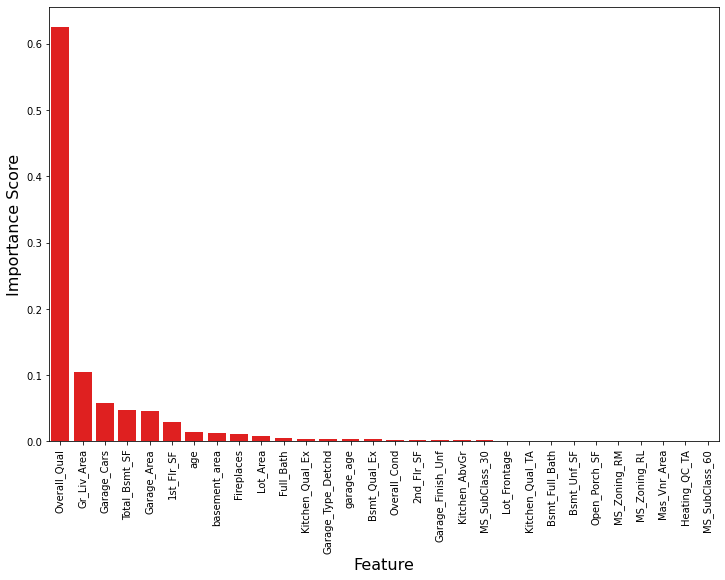

In [20]:
fig, axis = plt.subplots(1,1,figsize=(12,8))
sns.barplot(data = sorted_features_df.iloc[:30,:], x = 'Feature', y = 'Score',ax = axis, color = 'red')
axis.set_xlabel('Feature',fontsize = 16)
axis.set_ylabel('Importance Score', fontsize = 16)
plt.xticks(rotation = 90);

In [21]:
X_overal = Ames.loc[:,['Overall_Qual']].copy()
Y = fitted_data
X_train, X_test, Y_train, Y_test = train_test_split(X_overal,Y, test_size = 0.33, random_state = 144)

In [31]:
X_overal.shape

(2930, 1)

In [22]:
ols = linear_model.LinearRegression()

In [23]:
ols.fit(X_train,Y_train)
R2_train = np.round(ols.score(X_train,Y_train),3)
R2_test  = np.round(ols.score(X_test,Y_test),3)
print('Training score is :'+ str(R2_train))
print('Testing  score is :'+ str(R2_test))

Training score is :0.696
Testing  score is :0.651


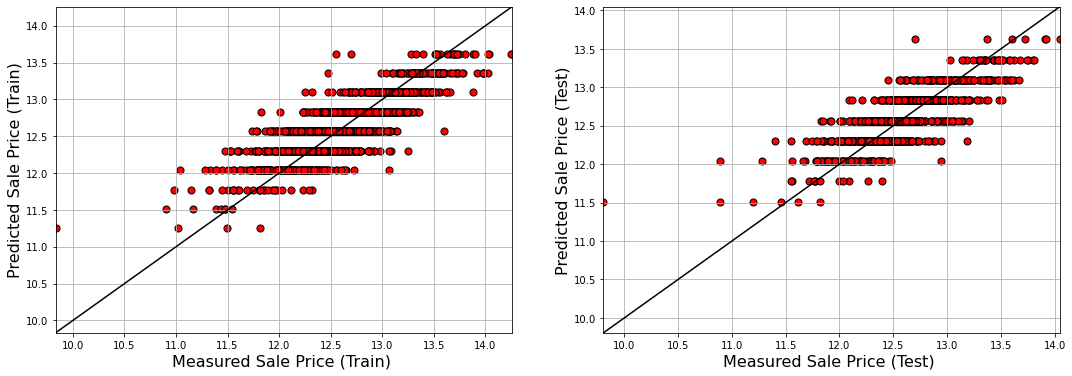

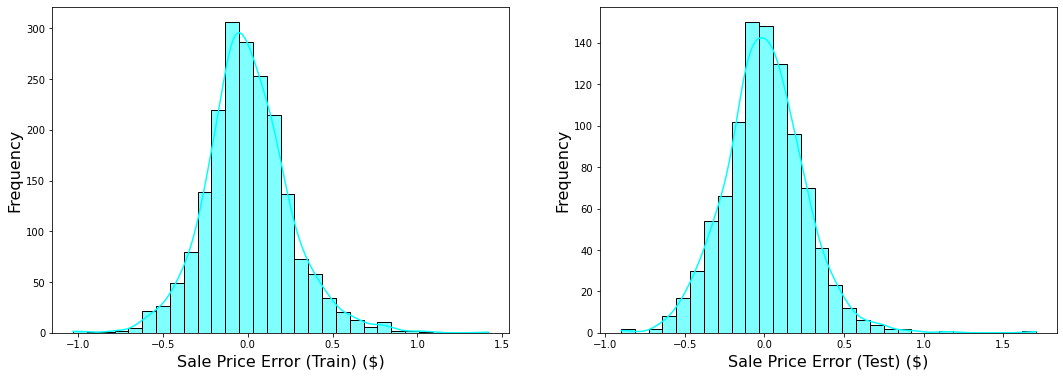

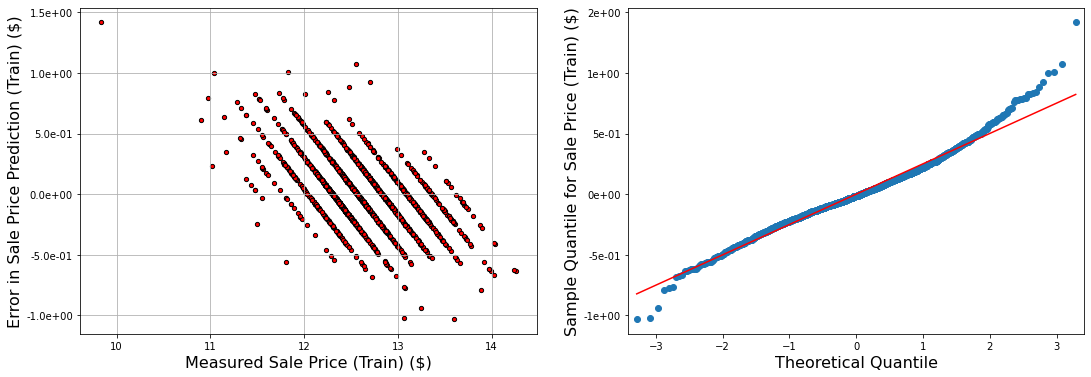

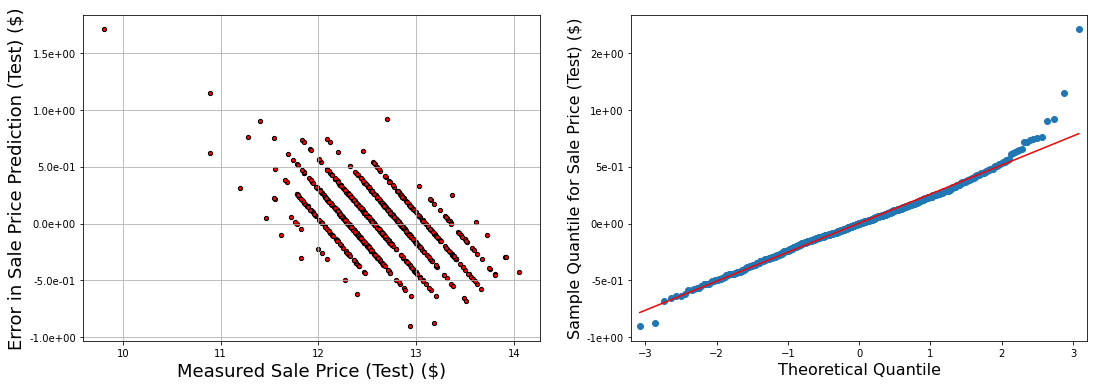

In [24]:
plot_randomforest(ols,X_train,X_test,Y_train,Y_test)

In [25]:
from sklearn.preprocessing import PolynomialFeatures

In [26]:
poly = PolynomialFeatures(degree=2, include_bias=False)

In [27]:
poly_features = poly.fit_transform(X_overal)

In [28]:
poly_features.shape

(2930, 2)

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(poly_features, Y, test_size = 0.33, random_state = 144)
ols = linear_model.LinearRegression()
ols.fit(X_train,Y_train)
R2_train = np.round(ols.score(X_train,Y_train),3)
R2_test  = np.round(ols.score(X_test,Y_test),3)
print('Training score is :'+ str(R2_train))
print('Testing  score is :'+ str(R2_test))

Training score is :0.696
Testing  score is :0.651


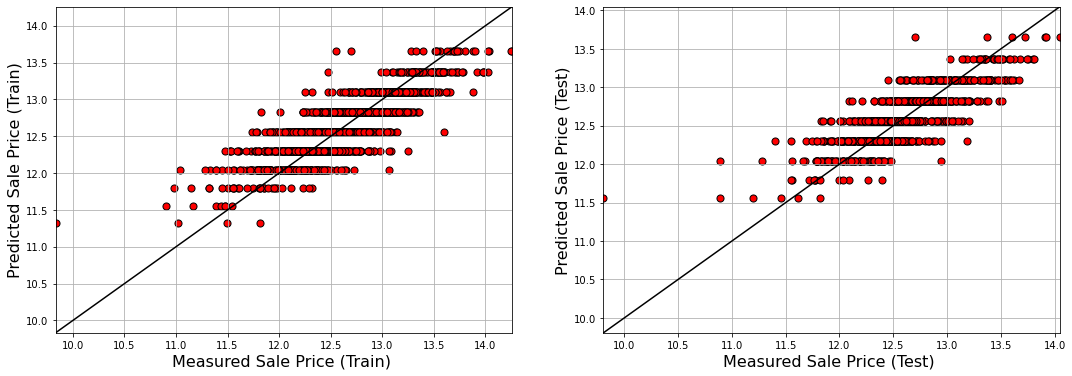

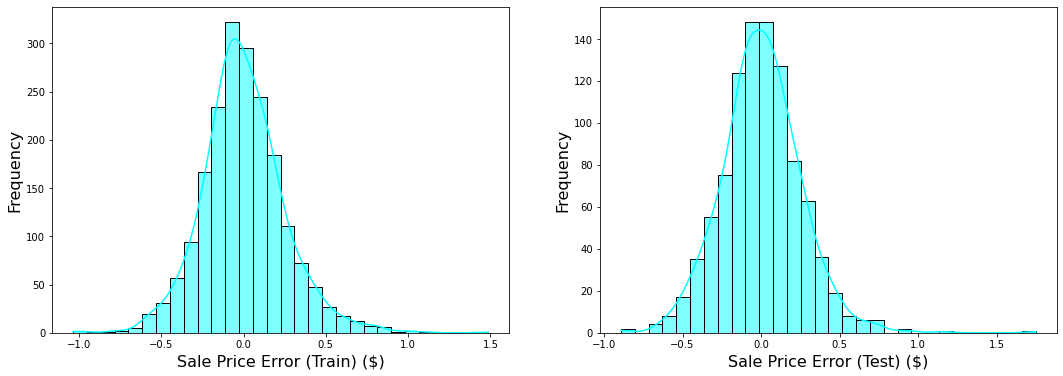

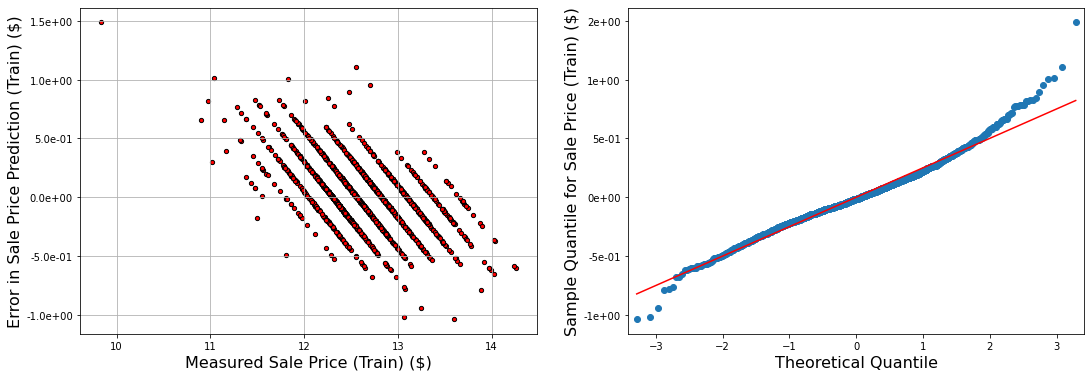

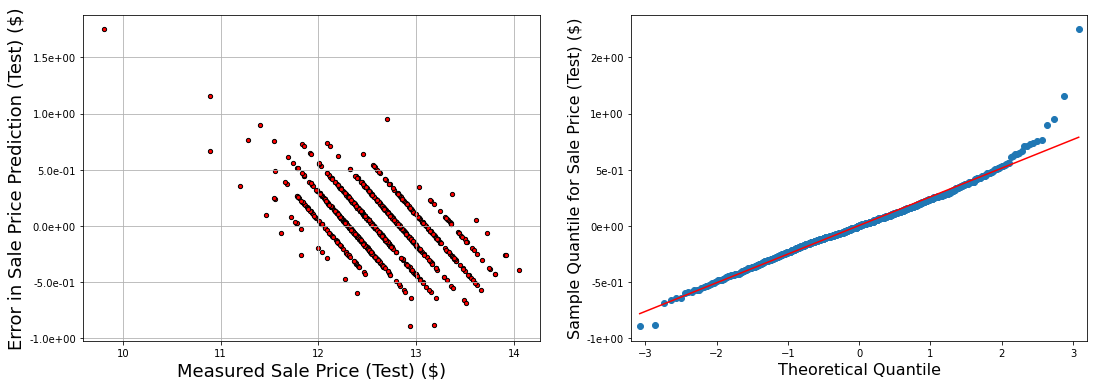

In [30]:
plot_randomforest(ols,X_train,X_test,Y_train,Y_test)

In [34]:
import statsmodels.api as sm

In [35]:
X = AmesFinal
Y = fitted_data
Y_stratify = pd.cut(Y,bins = 10)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 144, stratify = Y_stratify)

In [36]:
X_const = sm.add_constant(X_train)

In [37]:
mod = sm.OLS(Y_train,X_const)

In [38]:
res = mod.fit()

In [39]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     99.85
Date:                Thu, 22 Sep 2022   Prob (F-statistic):               0.00
Time:                        20:18:28   Log-Likelihood:                 1387.9
No. Observations:                1963   AIC:                            -2326.
Df Residuals:                    1738   BIC:                            -1070.
Df Model:                         224                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [40]:
res.params

const             1.886010
Lot_Frontage      0.000160
Lot_Area          0.000002
Overall_Qual      0.053891
Overall_Cond      0.047159
                    ...   
Garage_Qual_Ex    0.462033
Garage_Qual_Fa    0.329199
Garage_Qual_Gd    0.376980
Garage_Qual_Po    0.364984
Garage_Qual_TA    0.352814
Length: 255, dtype: float64

In [43]:
type(res.pvalues)

pandas.core.series.Series

In [49]:
ols_pval_df = pd.DataFrame(data = res.pvalues.values, index = list(res.pvalues.index)).reset_index()
ols_pval_df.columns = ['Feature','pValue']
ols_pval_df.sort_values(by='pValue',ascending = True, inplace=True)
ols_pval_df.head(80)

,Feature,pValue
0,const,0.000000e+00
151,Bsmt_Exposure_Av,0.000000e+00
152,Bsmt_Exposure_Gd,0.000000e+00
154,Bsmt_Exposure_No,0.000000e+00
187,Garage_Finish_Fin,0.000000e+00
...,...,...
191,Mo_Sold_2,5.982280e-31
3,Overall_Qual,1.185945e-29
109,Bldg_Type_Duplex,1.266151e-28
41,MS_SubClass_90,1.266151e-28
